In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import numba
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 5)
pd.set_option('display.max_rows', 100)

Populating the interactive namespace from numpy and matplotlib


,series1
Date,
2013-01-01,145
2013-01-02,1129
...,...
2016-09-29,1018
2016-09-30,1117


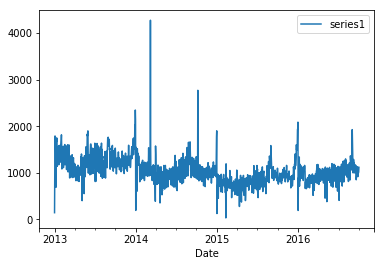

In [3]:
series = pd.read_excel('./inputs/Задания_1_2.xlsx', sheet_name='Timeseries', index_col='Date', parse_dates=True)
display(series)
series.plot()